In [1]:
import sys
from pathlib import Path

from rich.jupyter import display

ROOT = Path().resolve().parent
sys.path.append(str(ROOT))


In [2]:
import pandas as pd
from sklearn.metrics import confusion_matrix

from research.urgency import UrgencyPredictorNLP
from research.scarcity import ScarcityPredictorNLP
urgency_dataset = pd.read_csv("datasets/urgency.csv")


urgency_predictor  = UrgencyPredictorNLP()


# Predict only giving the text column
y_true = urgency_dataset["is_urgency"]
y_pred = urgency_predictor.predict_multiple(urgency_dataset["text"])

confusion_matrix(y_true, y_pred)

array([[11,  0],
       [ 0, 25]], dtype=int64)

In [3]:

scarcity_dataset = pd.read_csv("datasets/scarcity.csv" )
scarcity_predictor = ScarcityPredictorNLP()
y_true = scarcity_dataset["is_scarcity"]
y_pred = scarcity_predictor.predict_multiple(scarcity_dataset["text"])
confusion_matrix(y_true, y_pred)

array([[2, 0],
       [2, 8]], dtype=int64)

In [4]:
# Read from the datasets/images directory, get all the name of files, count scarcity and urgency based on if it's in the name

import os
from collections import Counter

directory_path = "datasets/images"

file_metrics = Counter({'scarcity': 0, 'urgency': 0, 'other': 0})

if os.path.exists(directory_path):
    files = [f.lower() for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

    for filename in files:
        if "scarcity" in filename:
            file_metrics['scarcity'] += 1
        elif "urgency" in filename:
            file_metrics['urgency'] += 1
        else :
            file_metrics['other'] += 1
    print(f"Total Files Scanned: {len(files)}")
    print(f"Scarcity Count: {file_metrics['scarcity']}")
    print(f"Urgency Count: {file_metrics['urgency']}")
    print(f"Other Count: {file_metrics['other']}")
else:
    print(f"Error: The directory '{directory_path}' was not found.")

Total Files Scanned: 104
Scarcity Count: 39
Urgency Count: 58
Other Count: 7


In [7]:
import csv
from collections import Counter

counts = Counter()

with open("datasets/unified_dataset.csv", newline="", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        counts[row["type"]] += 1

for k, v in counts.items():
    print(f"{k}: {v}")




fake_urgency: 185
fake_scarcity: 55
social_proof: 208
social_proof|fake_scarcity: 15
ninguno: 62
fake_urgency|fake_scarcity: 7
shaming: 72
: 234


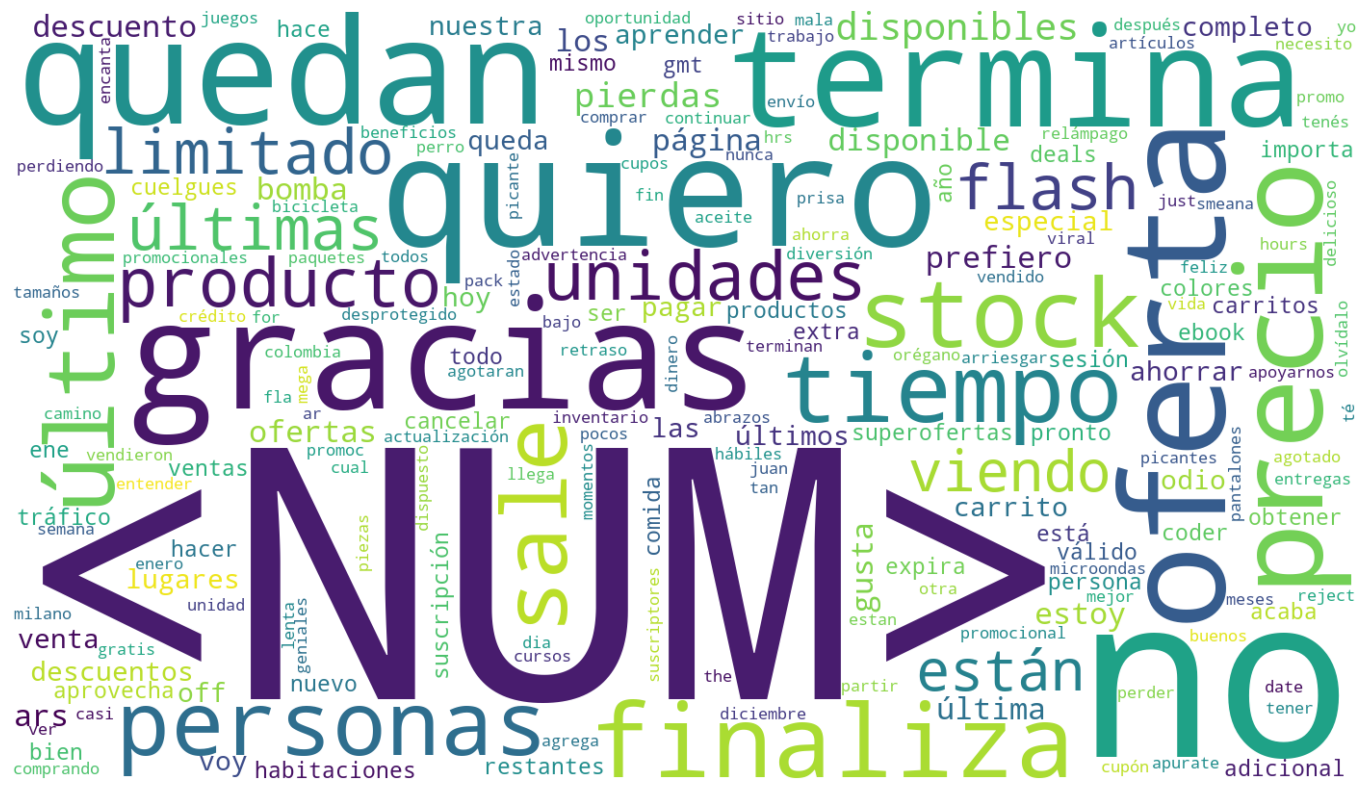

In [6]:
# pip install wordcloud matplotlib

import csv
import re
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

STOPWORDS_ES = {
    "de","la","el","y","a","en","por","para","con","sin","un","una","unos","unas",
    "lo","al","del","que","se","es","este","esta","estos","estas","hay","más","mas",
    "ya","ahora","solo","sólo","muy","tu","tú","su","sus","mi","mis","te","vos","ustedes",
    "desde","hasta","o","u","pero","si","sí","me","le","les","esto","eso","esa","ese",
    "min","mins","seg","segs","hs","hora","horas","minutos","segundos","día","dias","días"
}

def tokenize(text: str):
    text = text.lower()
    # normalizar números/contadores para que no dominen la nube
    text = re.sub(r"\d+([:.,]\d+)*", " <NUM> ", text)  # 03:16:29:07, 11:58:14, 87%, etc
    text = re.sub(r"[^\wáéíóúñü<>]+", " ", text, flags=re.UNICODE)
    tokens = [t for t in text.split() if t not in STOPWORDS_ES and len(t) > 1]
    return tokens

# --- cargar CSV y construir texto ---
tokens = []
with open("datasets/unified_dataset.csv", newline="", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        tokens.extend(tokenize(row["content"]))

freq = Counter(tokens)

# --- nube ---
wc = WordCloud(
    width=1400,
    height=800,
    background_color="white",
    collocations=False,  # evita juntar bigramas raros
    max_words=200
).generate_from_frequencies(freq)

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
plt.imshow(wc.to_image(), interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.show()



=== Classification report ===
               precision    recall  f1-score   support

fake_scarcity      0.727     0.800     0.762        10
 fake_urgency      0.818     0.750     0.783        12
      ninguno      0.714     0.625     0.667         8
      shaming      0.875     1.000     0.933         7

     accuracy                          0.784        37
    macro avg      0.784     0.794     0.786        37
 weighted avg      0.782     0.784     0.780        37

=== Confusion matrix ===


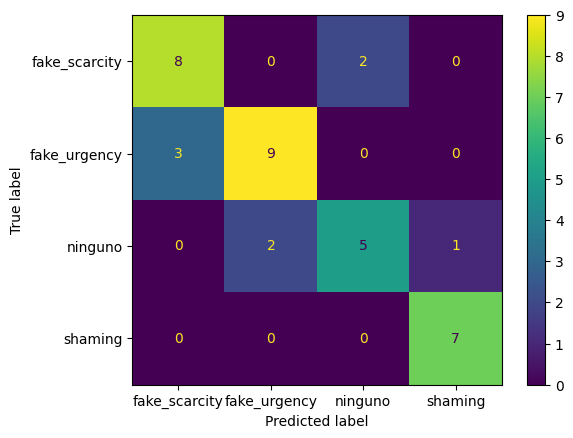

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

CSV_PATH = "datasets/unified_dataset.csv"

df = pd.read_csv(CSV_PATH)

# Limpieza mínima
df = df.dropna(subset=["type", "content", "source"])
df["type"] = df["type"].astype(str).str.strip()
df["content"] = df["content"].astype(str).str.strip()
df["source"] = df["source"].astype(str).str.strip()

X = df["content"]
y = df["type"]
groups = df["source"]

# --- Elegí UNA de estas dos estrategias de split ---

# (A) Split normal estratificado (más fácil, pero puede “memorizar” estilo de sitios)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


model = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        ngram_range=(1, 2),      # unigramas + bigramas
        min_df=2,                # ignora palabras ultra raras (ajustable)
        max_df=0.95,             # ignora palabras demasiado comunes
        strip_accents=None       # en español prefiero no tocar acentos
    )),
    ("clf", LinearSVC())
])

model.fit(X_train, y_train)
pred = model.predict(X_test)

print("=== Classification report ===")
print(classification_report(y_test, pred, digits=3))

print("=== Confusion matrix ===")
labels = sorted(y.unique())
cm = confusion_matrix(y_test, pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(values_format="d")
plt.show()


=== OOF Classification report (GroupKFold por source) ===
               precision    recall  f1-score   support

fake_scarcity      0.780     0.812     0.796        48
 fake_urgency      0.667     0.825     0.738        63
      ninguno      0.565     0.342     0.426        38
      shaming      0.853     0.806     0.829        36

     accuracy                          0.719       185
    macro avg      0.716     0.696     0.697       185
 weighted avg      0.711     0.719     0.706       185



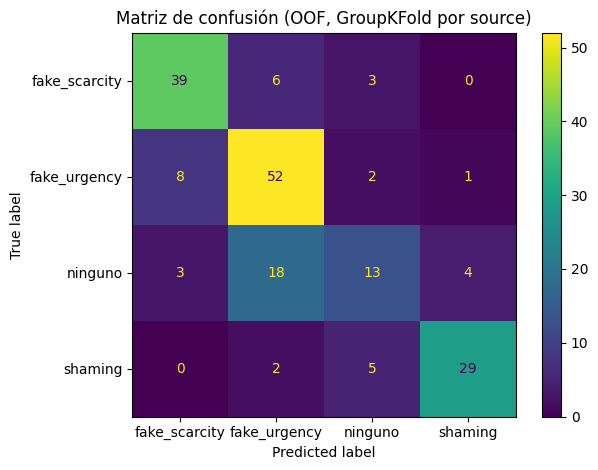

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

df = pd.read_csv("datasets/unified_dataset.csv").dropna(subset=["type", "content", "source"])
df["type"] = df["type"].astype(str).str.strip()
df["content"] = df["content"].astype(str).str.strip()
df["source"] = df["source"].astype(str).str.strip()
# df = df[df["type"] != "ninguno"]

X = df["content"]
y = df["type"]
groups = df["source"]

labels = sorted(y.unique())

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        ngram_range=(1, 3),
        min_df=1,
        max_df=0.95
    )),
    ("clf", LinearSVC(class_weight="balanced"))
])

gkf = GroupKFold(n_splits=5)

# Predicciones out-of-fold (cada ejemplo se predice cuando su grupo está en test)
oof_pred = np.empty(len(df), dtype=object)

for train_idx, test_idx in gkf.split(X, y, groups):
    pipeline.fit(X.iloc[train_idx], y.iloc[train_idx])
    oof_pred[test_idx] = pipeline.predict(X.iloc[test_idx])

print("=== OOF Classification report (GroupKFold por source) ===")
print(classification_report(y, oof_pred, labels=labels, digits=3, zero_division=0))

cm = confusion_matrix(y, oof_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(values_format="d")  # números enteros
plt.title("Matriz de confusión (OOF, GroupKFold por source)")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
df = pd.read_csv("datasets/unified_dataset.csv").dropna(subset=["type","content","source"])

df["binary"] = df["type"].apply(
    lambda x: "pattern" if x in ["fake_urgency","fake_scarcity", "shaming"] else "ninguno"
)

X = df["content"]
y = df["binary"]
groups = df["source"]

pipeline_stage1 = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,3), min_df=1, max_df=0.95)),
    ("clf", LogisticRegression(max_iter=3000, class_weight={"pattern": 1.0, "ninguno": 2.0}))
])

gkf = GroupKFold(n_splits=5)

oof_pred = np.empty(len(df), dtype=object)

for tr, te in gkf.split(X, y, groups):
    pipeline_stage1.fit(X.iloc[tr], y.iloc[tr])
    oof_pred[te] = pipeline_stage1.predict(X.iloc[te])

print("=== STAGE 1: pattern vs ninguno ===")
print(classification_report(y, oof_pred, digits=3))


df_p = df[df["type"] != "ninguno"]

X2 = df_p["content"]
y2 = df_p["type"]
groups2 = df_p["source"]


pipeline_stage2 = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,3),
        min_df=1,
        max_df=0.95
    )),
    ("clf", LinearSVC(class_weight="balanced"))
])

gkf = GroupKFold(n_splits=5)
oof_pred2 = np.empty(len(df_p), dtype=object)

for tr, te in gkf.split(X2, y2, groups2):
    pipeline_stage2.fit(X2.iloc[tr], y2.iloc[tr])
    oof_pred2[te] = pipeline_stage2.predict(X2.iloc[te])

print("=== STAGE 2: urgency vs scarcity vs shaming ===")
print(classification_report(y2, oof_pred2, digits=3))

# =========================
# ERRORES STAGE 1
# =========================
df_stage1_err = df.copy()
df_stage1_err["y_true"] = y.values
df_stage1_err["y_pred"] = oof_pred

# solo errores
df_stage1_err = df_stage1_err[df_stage1_err["y_true"] != df_stage1_err["y_pred"]]

print(f"Total errores Stage 1: {len(df_stage1_err)}")

# Falsos negativos: pattern -> ninguno
fn = df_stage1_err[
    (df_stage1_err["y_true"] == "pattern") &
    (df_stage1_err["y_pred"] == "ninguno")
]

print("\n=== FALSOS NEGATIVOS (pattern → ninguno) ===")
for _, r in fn.iterrows():
    print(f"- [{r['source']}] {r['content']}")

# Falsos positivos: ninguno -> pattern
fp = df_stage1_err[
    (df_stage1_err["y_true"] == "ninguno") &
    (df_stage1_err["y_pred"] == "pattern")
]

print("\n=== FALSOS POSITIVOS (ninguno → pattern) ===")
for _, r in fp.iterrows():
    print(f"- [{r['source']}] {r['content']}")




=== STAGE 1: pattern vs ninguno ===
              precision    recall  f1-score   support

     ninguno      0.600     0.079     0.140        38
     pattern      0.806     0.986     0.887       147

    accuracy                          0.800       185
   macro avg      0.703     0.533     0.513       185
weighted avg      0.763     0.800     0.733       185

=== STAGE 2: urgency vs scarcity vs shaming ===
               precision    recall  f1-score   support

fake_scarcity      0.830     0.812     0.821        48
 fake_urgency      0.824     0.889     0.855        63
      shaming      1.000     0.889     0.941        36

     accuracy                          0.864       147
    macro avg      0.884     0.863     0.872       147
 weighted avg      0.869     0.864     0.865       147

Total errores Stage 1: 37

=== FALSOS NEGATIVOS (pattern → ninguno) ===
- [Desconocido] Olvídalo, quiero juegos geniales
- [NeilPatel] Si, quiero más tráfico

=== FALSOS POSITIVOS (ninguno → pattern) =

In [10]:
import pandas as pd
from sklearn.metrics import classification_report

# --- paths ---
SCARCITY_PATH = "datasets/scarcity.csv"
URGENCY_PATH  = "datasets/urgency.csv"

# --- load ---
df_sc = pd.read_csv(SCARCITY_PATH)   # is_scarcity, text, origin
df_ur = pd.read_csv(URGENCY_PATH)    # is_urgency,  text, path

# --- normalize schemas ---
df_sc = df_sc.rename(columns={"is_scarcity":"label", "origin":"meta"})
df_sc["task"] = "scarcity"

df_ur = df_ur.rename(columns={"is_urgency":"label", "path":"meta"})

df_ur["task"] = "urgency"

df_test = pd.concat([df_sc[["label","text","task","meta"]],
                     df_ur[["label","text","task","meta"]]], ignore_index=True)

df_test["label"] = df_test["label"].astype(int)
df_test["text"]  = df_test["text"].astype(str).str.strip()

# ground truth binaria (pattern vs ninguno)
y_true_stage1 = df_test["label"].map({1: "pattern", 0: "ninguno"})
X_test = df_test["text"]

# =========================
# STAGE 1 — pattern vs ninguno
# =========================
y_pred_stage1 = pipeline_stage1.predict(X_test)

print("=== EXTERNAL TEST — STAGE 1 (pattern vs ninguno) ===")
print(classification_report(
    y_true_stage1,
    y_pred_stage1,
    digits=3,
    zero_division=0
))

# =========================
# STAGE 2 — urgency vs scarcity (solo patterns verdaderos que además pasaron stage1)
# =========================
mask = (df_test["label"] == 1) & (y_pred_stage1 == "pattern")

X_stage2 = df_test.loc[mask, "text"]
y_true_stage2 = df_test.loc[mask, "task"].map({"urgency":"fake_urgency", "scarcity":"fake_scarcity"})

if len(X_stage2) == 0:
    print("\n(No hay ejemplos que hayan pasado Stage 1 como 'pattern' para evaluar Stage 2.)")
else:
    y_pred_stage2 = pipeline_stage2.predict(X_stage2)

    print("\n=== EXTERNAL TEST — STAGE 2 (urgency vs scarcity) ===")
    print(classification_report(
        y_true_stage2,
        y_pred_stage2,
        digits=3,
        zero_division=0
    ))

    # opcional: ver cuáles falló
    wrong = df_test.loc[mask].copy()
    wrong["y_true"] = y_true_stage2.values
    wrong["y_pred"] = y_pred_stage2
    wrong = wrong[wrong["y_true"] != wrong["y_pred"]]
    if len(wrong):
        print("\n--- Errores Stage 2 (muestra) ---")
        display(wrong[["task","text","meta","y_true","y_pred"]].head(30))



    # dataframe con resultados
df_errors = df_test.copy()
df_errors["y_true"] = y_true_stage1.values
df_errors["y_pred"] = y_pred_stage1

# solo errores
df_errors = df_errors[df_errors["y_true"] != df_errors["y_pred"]]

print(f"Total errores Stage 1: {len(df_errors)}")

# -------------------------
# Falsos negativos
# pattern → ninguno
# -------------------------
fn = df_errors[(df_errors["y_true"] == "pattern") & (df_errors["y_pred"] == "ninguno")]

print("\n=== FALSOS NEGATIVOS (pattern → ninguno) ===")
for _, r in fn.iterrows():
    print(f"- TEXT: {r['text']}")

# -------------------------
# Falsos positivos
# ninguno → pattern
# -------------------------
fp = df_errors[(df_errors["y_true"] == "ninguno") & (df_errors["y_pred"] == "pattern")]

print("\n=== FALSOS POSITIVOS (ninguno → pattern) ===")
for _, r in fp.iterrows():
    print(f"- TEXT: {r['text']}")



=== EXTERNAL TEST — STAGE 1 (pattern vs ninguno) ===
              precision    recall  f1-score   support

     ninguno      0.440     0.846     0.579        13
     pattern      0.913     0.600     0.724        35

    accuracy                          0.667        48
   macro avg      0.677     0.723     0.652        48
weighted avg      0.785     0.667     0.685        48


=== EXTERNAL TEST — STAGE 2 (urgency vs scarcity) ===
               precision    recall  f1-score   support

fake_scarcity      1.000     1.000     1.000         8
 fake_urgency      1.000     1.000     1.000        13

     accuracy                          1.000        21
    macro avg      1.000     1.000     1.000        21
 weighted avg      1.000     1.000     1.000        21

Total errores Stage 1: 16

=== FALSOS NEGATIVOS (pattern → ninguno) ===
- TEXT: ¡Compra ahora mismo antes de que se acabe!
- TEXT: En 18 carritos
- TEXT: ¡Compra ahora mismo antes de que se acabe!
- TEXT: Ends in 7h 16m 2s
- TEXT: N

In [11]:
import pandas as pd
from sklearn.metrics import classification_report
from research.urgency import UrgencyPredictorNLP
from research.scarcity import ScarcityPredictorNLP

df = pd.read_csv("datasets/unified_dataset.csv").dropna(subset=["type","content","source"])
df["type"] = df["type"].astype(str).str.strip()
df["content"] = df["content"].astype(str).str.strip()
df["source"] = df["source"].astype(str).str.strip()

scar_model = ScarcityPredictorNLP()
urg_model  = UrgencyPredictorNLP()

def eval_with_strategy(df, target_type: str, strategy, title: str):
    y_true = (df["type"] == target_type).astype(int).to_numpy()

    # usa la clase (predict_multiple)
    preds_bool = strategy.predict_multiple(df["content"])
    y_pred = pd.Series(preds_bool).astype(int).to_numpy()

    print(f"\n=== {title} ===")
    print(classification_report(y_true, y_pred, digits=3, zero_division=0))

    # errores (FP/FN)
    tmp = df.copy()
    tmp["y_true"] = y_true
    tmp["y_pred"] = y_pred
    err = tmp[tmp["y_true"] != tmp["y_pred"]]

    fp = err[(err["y_true"] == 0) & (err["y_pred"] == 1)]
    fn = err[(err["y_true"] == 1) & (err["y_pred"] == 0)]

    print(f"Errores totales: {len(err)} | FP: {len(fp)} | FN: {len(fn)}")

    print("\n-- FALSOS POSITIVOS (predijo True pero era otra clase) [hasta 25] --")
    for _, r in fp.head(25).iterrows():
        print(f"- TRUE={r['type']} | [{r['source']}] {r['content']}")

    print("\n-- FALSOS NEGATIVOS (no detectó, pero era la clase objetivo) [hasta 25] --")
    for _, r in fn.head(25).iterrows():
        print(f"- TRUE={r['type']} | [{r['source']}] {r['content']}")

# Scarcity vs resto
eval_with_strategy(
    df=df,
    target_type="fake_scarcity",
    strategy=scar_model,
    title="ScarcityPredictorNLP (fake_scarcity vs resto)"
)

# Urgency vs resto
eval_with_strategy(
    df=df,
    target_type="fake_urgency",
    strategy=urg_model,
    title="UrgencyPredictorNLP (fake_urgency vs resto)"
)



=== ScarcityPredictorNLP (fake_scarcity vs resto) ===
              precision    recall  f1-score   support

           0      0.801     0.942     0.866       137
           1      0.667     0.333     0.444        48

    accuracy                          0.784       185
   macro avg      0.734     0.637     0.655       185
weighted avg      0.766     0.784     0.756       185

Errores totales: 40 | FP: 8 | FN: 32

-- FALSOS POSITIVOS (predijo True pero era otra clase) [hasta 25] --
- TRUE=fake_urgency | [shein] -28% | Último día
- TRUE=fake_urgency | [shein] ¡Último día
- TRUE=fake_urgency | [temu] -29% últimos 2 días
- TRUE=fake_urgency | [temu] Último día
- TRUE=fake_urgency | [spotify] Última oportunidad
- TRUE=fake_urgency | [temu] Solo quedan 12 horas para obtener 21% de descuento
- TRUE=ninguno | [wish] 4 colores, 5 piezas
- TRUE=ninguno | [IA] Últimas unidades disponibles

-- FALSOS NEGATIVOS (no detectó, pero era la clase objetivo) [hasta 25] --
- TRUE=fake_scarcity | [africa